In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# plt.rcParams['figure.figsize'] = (20,20)

from tensorflow.keras import Model

from PIL import Image

2024-05-20 18:45:45.497526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 18:45:46.103493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Preparation

In [2]:
#directory
train_dir = 'Binary2/Train'
val_dir = 'Binary2/Validation'

In [3]:
#visualize Image before Augmentation
train_pneumonia_img = glob(train_dir + '/Pneumonia/*.PNG') + glob(train_dir + '/Pneumonia/*.png') + glob(train_dir + '/Pneumonia/*.jpg') + glob(train_dir + '/Pneumonia/*.jpeg')
train_normal_img = glob(train_dir + '/Normal/*.PNG') + glob(train_dir + '/Normal/*.png') + glob(train_dir + '/Normal/*.jpg') + glob(train_dir + '/Normal/*.jpeg')

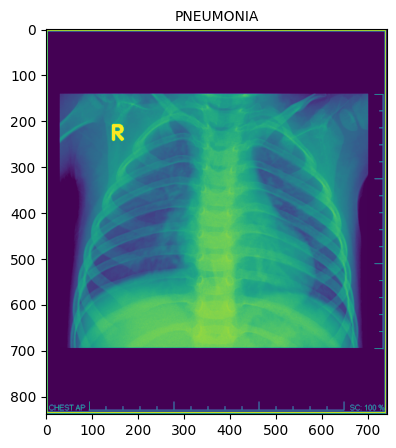

(839, 742)


In [4]:
#gausa di convert ke Gray
pneumonia_img = Image.open(train_pneumonia_img[0])

#convert RGBA to RGB
# pneumonia_rgb = pneumonia_img.convert('RGB')

#convert to grayscale
pneumonia_gray = pneumonia_img.convert('L')

pneumonia = np.asarray(pneumonia_gray)

plt.figure(figsize=(5, 5))
plt.title('PNEUMONIA', fontsize=10, color='black')
plt.imshow(pneumonia)
plt.show()

print(pneumonia.shape)

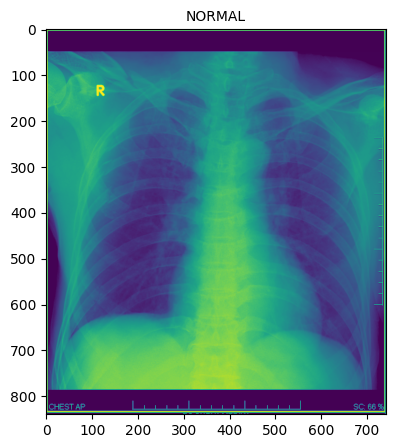

(840, 741)


In [5]:
normal_img = Image.open(train_normal_img[0])

#convert RGBA to RGB
# pneumonia_rgb = pneumonia_img.convert('RGB')

#convert to grayscale
normal_gray = normal_img.convert('L')

normal = np.asarray(normal_gray)

plt.figure(figsize=(5, 5))
plt.title('NORMAL', fontsize=10, color='black')
plt.imshow(normal)
plt.show()

print(normal.shape)

In [6]:
# pneumonia = np.asarray(plt.imread(train_pneumonia_img[0]))
# normal = np.asarray(plt.imread(train_normal_img[0]))

In [7]:
# plt.figure(figsize = (5,5))
# plt.title('PNEUMONIA',fontsize=10,color='black')
# plt.imshow(pneumonia)
# print(pneumonia.shape) #kok shape x,x,4 ???

In [8]:
# plt.figure(figsize = (5,5))
# plt.title('NORMAL',fontsize=10,color='black')
# plt.imshow(normal)
# print(normal.shape) #kok shape x,x,4 ???

Data Preprocessing

In [9]:
from skimage import exposure

# Define a custom preprocessing function to adjust brightness and contrast
def adjust_brightness_contrast(image):
    # Adjust brightness and contrast using skimage
    image = exposure.adjust_gamma(image, gamma=1.05)  # Example gamma value, adjust as needed
    return image


In [10]:
#ImageDataGenerator for training and test

datagen = ImageDataGenerator(validation_split = 0.25,
                             rescale = 1./255,
                             preprocessing_function=adjust_brightness_contrast,
                             horizontal_flip = False,
                             vertical_flip = False)
#ImageDataGenerator for val set
val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
IMG_SIZE = (224,224)
train_set = datagen.flow_from_directory(train_dir,
                                        subset = 'training',
                                        classes = ['Pneumonia', 'Normal'],
                                        class_mode = 'binary',
                                        batch_size = 32,
                                        target_size = IMG_SIZE)

Found 194 images belonging to 2 classes.


In [12]:
test_set = datagen.flow_from_directory(train_dir,
                                       subset = 'validation',
                                       classes = ['Pneumonia', 'Normal'],
                                       class_mode = 'binary',
                                       batch_size = 32,
                                       target_size = IMG_SIZE)

Found 64 images belonging to 2 classes.


In [13]:
# X_train, y_train = train_set.next()
# X_test, y_test = test_set.next()

In [14]:
for batch in train_set:
    X_train, y_train = batch
    break #Exit loop after processing the first batch

for batch in test_set:
    X_test, y_test = batch
    break

In [15]:
print(len(X_train), len(y_train))

32 32


In [16]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(32, 224, 224, 3) Y=(32,)
Test X=(32, 224, 224, 3) Y=(32,)


<Axes: xlabel='count'>

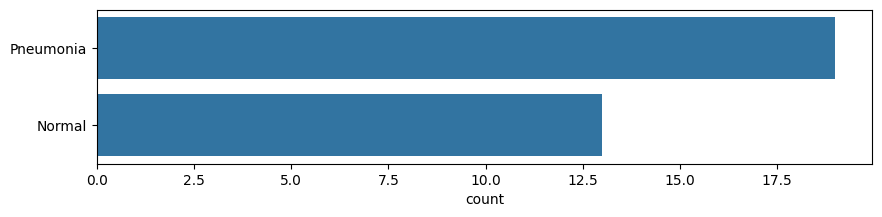

In [17]:
labels = ['Pneumonia' if label == 0 else 'Normal' for label in y_train]
fig = plt.subplots(figsize=(10,2))
sns.countplot(labels)

#check the labels, 0 for what?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

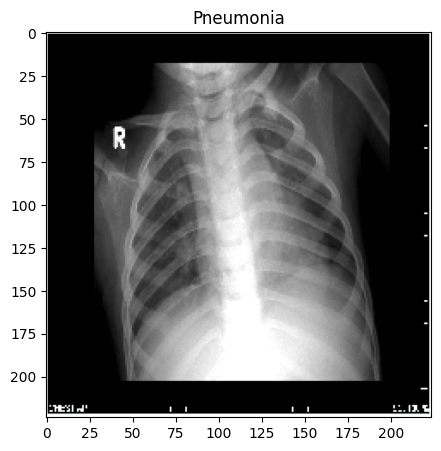

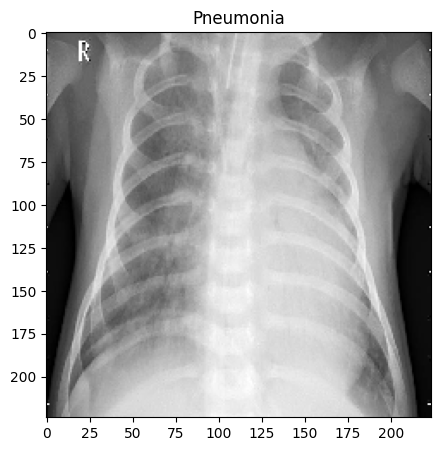

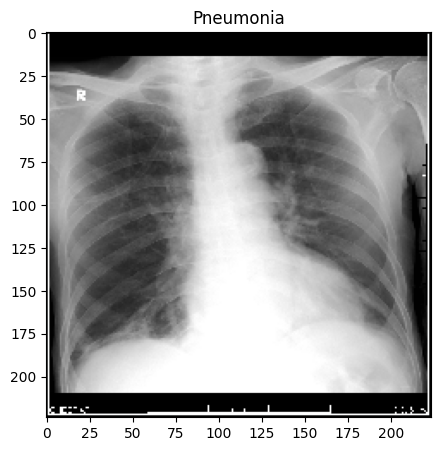

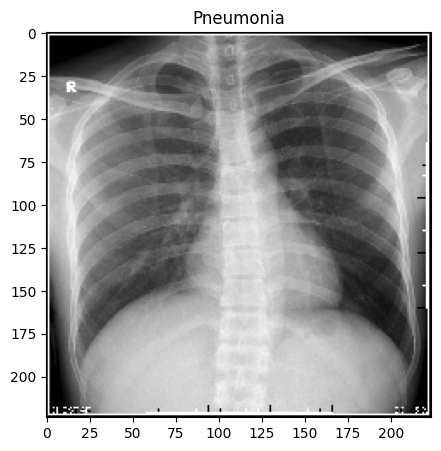

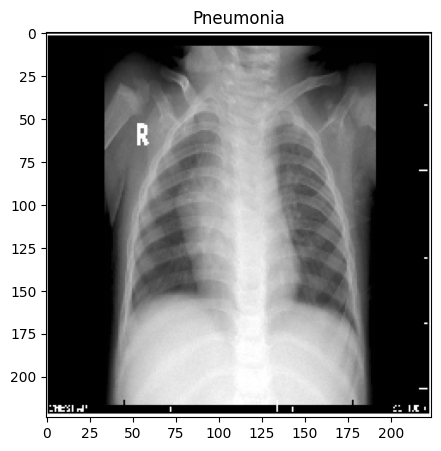

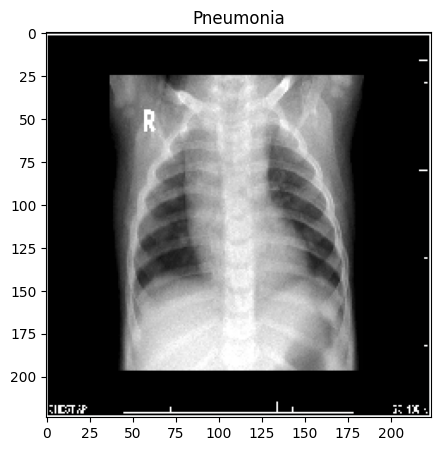

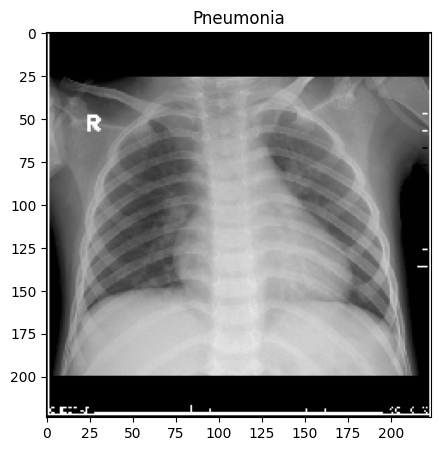

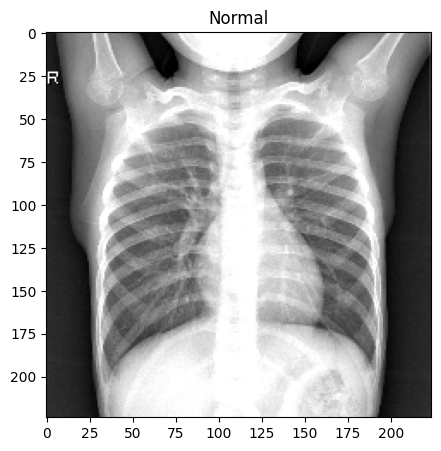

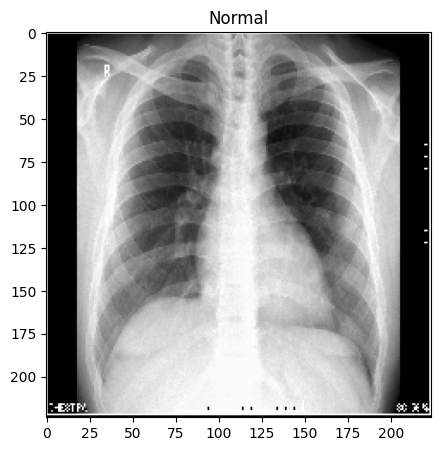

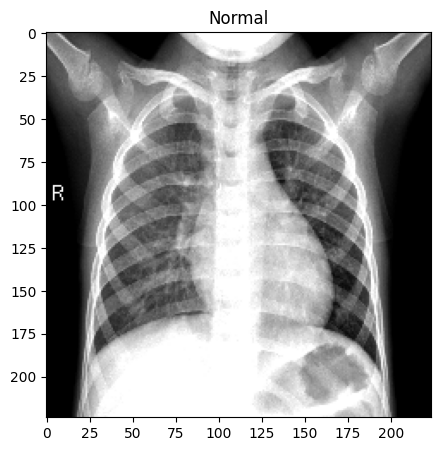

In [18]:
for augdata in range(10):
    plt.figure(figsize=(5,5))
    plt.imshow(X_train[augdata])
    plt.title(labels[augdata])

#why the green background?

In [19]:
X_train[0].shape

(224, 224, 3)

In [20]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('V10_VGG16NormalPneumonia.keras')

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9) and (logs.get('loss') <= 0.1 and logs.get('val_loss') <= 0.1):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False

custom_cb = CustomCallback()

In [21]:
VGGModel = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classifier_activation='softmax'
)

VGGModel.trainable = False

2024-05-20 18:45:49.881438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 18:45:49.884600: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
x = tf.keras.layers.Flatten()(VGGModel.output)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=VGGModel.input, outputs=outputs)


In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,04

 Total params: 28,612,929 (109.15 MB)

 Trainable params: 13,898,241 (53.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Define the learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

In [25]:
model.compile(loss='binary_crossentropy',
                       optimizer=tf.optimizers.Adam(),
                       metrics=['accuracy'])

In [26]:
hist = model.fit(
    train_set,
    validation_data = test_set,
    epochs = 32,
    callbacks=[checkpoint_cb])

Epoch 1/32


/home/isb/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5168 - loss: 1.6175 - val_accuracy: 0.8906 - val_loss: 0.2596
Epoch 2/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7484 - loss: 0.4398 - val_accuracy: 0.8438 - val_loss: 0.3737
Epoch 3/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8298 - loss: 0.4403 - val_accuracy: 0.9844 - val_loss: 0.0452
Epoch 4/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 913ms/step - accuracy: 0.8571 - loss: 0.3290 - val_accuracy: 0.9375 - val_loss: 0.1373
Epoch 5/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 917ms/step - accuracy: 0.8929 - loss: 0.2300 - val_accuracy: 0.9531 - val_loss: 0.0736
Epoch 6/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 916ms/step - accuracy: 0.9405 - loss: 0.1456 - val_accuracy: 0.9531 - val_loss: 0.1119
Epoch 7/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 919ms/step - accuracy: 0.9542 - loss: 0.1087 - val_accuracy: 0.9844 - val_loss: 0.0258
Epoch 8/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 911ms/step - accuracy: 0.9114 - loss: 0.1778 - val_accuracy: 0.9844 - val_loss: 0.0314
Epoch 9/32


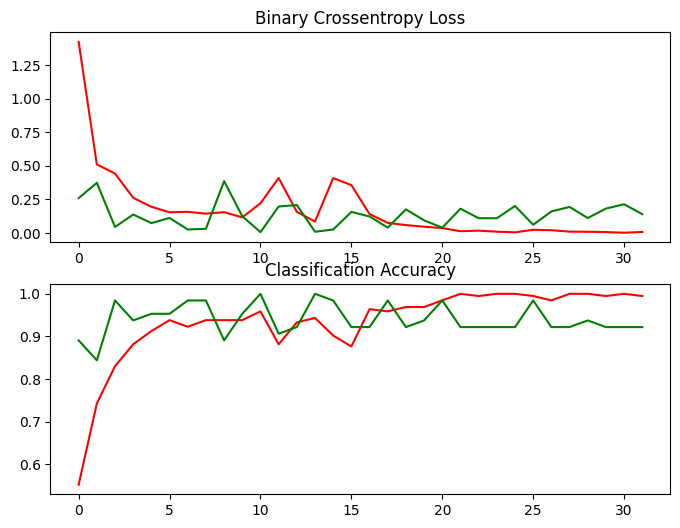

In [27]:
plt.figure(figsize=(8, 6)) 

plt.subplot(211)
plt.title('Binary Crossentropy Loss')
plt.plot(hist.history['loss'], color = 'red', label ='train')
plt.plot(hist.history['val_loss'], color = 'green', label ='val')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(hist.history['accuracy'], color = 'red', label ='train')
plt.plot(hist.history['val_accuracy'], color = 'green', label ='test')

plt.show()

Make Predictions

In [41]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_set = val_datagen.flow_from_directory(val_dir,
                                          batch_size = 32,
                                          classes = ['Pneumonia','Normal'],
                                          target_size = IMG_SIZE,
                                          class_mode='binary')
X_val, y_val = next(val_set)

Found 59 images belonging to 2 classes.


In [42]:
print('Loss of the model is - ', model.evaluate(X_val, y_val)[0])
print('Accuracy of the model is - ', model.evaluate(X_val, y_val)[1]*100, '%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - accuracy: 0.9375 - loss: 0.2118
Loss of the model is -  0.21183444559574127
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - accuracy: 0.9375 - loss: 0.2118
Accuracy of the model is -  93.75 %


In [43]:

predicted_probabilities = model.predict(X_val)
predicted_classes = (predicted_probabilities > 0.5).astype(int)  # Use a threshold of 0.5 for binary classification
predicted_classes = predicted_classes.reshape(1, -1)[0]
predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0])

In [44]:

predicted_probabilities = model.predict(X_test)
predicted_test = (predicted_probabilities > 0.5).astype(int)  # Use a threshold of 0.5 for binary classification
predicted_test = predicted_classes.reshape(1, -1)[0]
predicted_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0])

In [45]:
print(classification_report(y_val, predicted_classes, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      1.00      0.94        17
   Normal (Class 1)       1.00      0.87      0.93        15

           accuracy                           0.94        32
          macro avg       0.95      0.93      0.94        32
       weighted avg       0.94      0.94      0.94        32



In [46]:
print(classification_report(y_test, predicted_test, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.58      0.61      0.59        18
   Normal (Class 1)       0.46      0.43      0.44        14

           accuracy                           0.53        32
          macro avg       0.52      0.52      0.52        32
       weighted avg       0.53      0.53      0.53        32



In [47]:
print('Confusion Matrix\n')
matrix = confusion_matrix(y_val, predicted_classes)
print(matrix)

Confusion Matrix

[[17  0]
 [ 2 13]]


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score
precision = precision_score(y_val, predicted_classes)
recall = recall_score(y_val, predicted_classes)
f1 = f1_score(y_val, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 1.0
Recall: 0.8666666666666667
F1 Score: 0.9285714285714286


In [49]:
correct = np.nonzero(predicted_classes == y_val)[0]
incorrect = np.nonzero(predicted_classes != y_val)[0]
print(len(correct), len(incorrect))

30 2


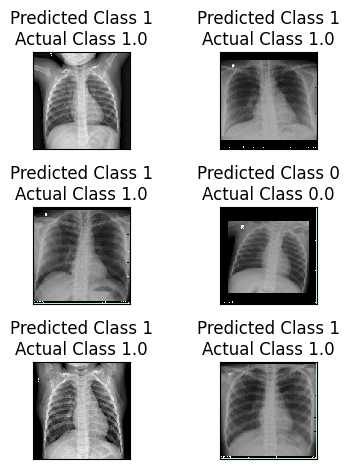

In [50]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predicted_classes[c], y_val[c]))
    plt.tight_layout()
    i += 1

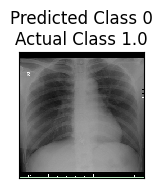

In [38]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predicted_classes[c], y_val[c]))
    plt.tight_layout()